In [1]:
########################################################################
#####                   DREAM - MPPC Recording                     #####
########################################################################

In [8]:
##### Import Libraries
import numpy as np
import pandas as pd
import time
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib widget
import datetime
from mcculw import ul
from ctypes import cast, POINTER, c_double, c_ushort, c_ulong 
from mcculw.enums import (ScanOptions, FunctionType, Status, ChannelType, 
    DigitalPortType, ULRange, TriggerSource, TriggerSensitivity, TriggerEvent, 
    DigitalIODirection, TimerIdleState, PulseOutOptions, TrigType)
from mcculw.device_info import DaqDeviceInfo

try:
    from console_examples_util import config_first_detected_device
except ImportError:
    from console_examples_util import config_first_detected_device
    
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools


## SETUP DAQ

In [2]:
from mcculw.enums import InterfaceType
devices = ul.get_daq_device_inventory(InterfaceType.USB)
for device in devices:
     print(ul.get_board_number(device))


-1


In [3]:
########################################################
##### SETUP EQUIPMENT

##### Connect to the DAQ Card
board_num = 0
daq_dev_info = DaqDeviceInfo(board_num = 0)

##### Setup DAQ for analog input
ai_info = daq_dev_info.get_ai_info()
ai_range = ai_info.supported_ranges[2]

## Set the scan options
scan_options_AI = ScanOptions.BACKGROUND

## AQUISITION SETTINGS

In [31]:
acquisition_settings = {
    'frequency': [128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
    'time_DAQ': [0.75, 1.5, 3, 6, 12, 24, 48, 96, 192, 384, 448, 896, 992, 1152, 2304],
    'DAQ_rate': [1280, 640, 320, 160, 80, 40, 20, 10, 5, 4, 2, 1, 1, 1, 1],
    'p_period': [10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 16, 16, 32, 64, 128]
}
acquisition_settings = pd.DataFrame(acquisition_settings)
acquisition_settings

,frequency,time_DAQ,DAQ_rate,p_period
0,128.000000,0.75,1280,10
1,64.000000,1.50,640,10
2,32.000000,3.00,320,10
3,16.000000,6.00,160,10
4,8.000000,12.00,80,10
5,4.000000,24.00,40,10
6,2.000000,48.00,20,10
7,1.000000,96.00,10,10
8,0.500000,192.00,5,10
9,0.250000,384.00,4,16


In [32]:
frequency = 4 # [Hz]

DAQ_Rate = acquisition_settings.loc[acquisition_settings['frequency'] == frequency, 'DAQ_rate'].values[0]
Exp_Duration = acquisition_settings.loc[acquisition_settings['frequency'] == frequency, 'time_DAQ'].values[0]
total_count = int(DAQ_Rate * Exp_Duration) + 1
EXPNAME = f"f_{frequency}_Hz"
p_period = acquisition_settings.loc[acquisition_settings['frequency'] == frequency, 'p_period'].values[0]

In [16]:
## Allocate a buffer for the input

if ai_info.resolution <= 16:
    # Use the win_buf_alloc method for devices with a resolution <= 16
    memhandle_AI = ul.win_buf_alloc(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ushort))
else:
    # Use the win_buf_alloc_32 method for devices with a resolution > 16
    memhandle_AI = ul.win_buf_alloc_32(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ulong))

if not memhandle_AI:
    raise Exception('Error: Failed to allocate memory')


## RUN EXPERIMENT

In [17]:
## Start the timer, which will start and pace AO and AI
ul.a_in_scan(board_num, 0, 0, (total_count), DAQ_Rate, ai_range, memhandle_AI, scan_options_AI)

## Wait until AI Finishes
status, curr_count, curr_index = ul.get_status(board_num, FunctionType.AIFUNCTION)
while status != Status.IDLE:
    time.sleep(0.5)
    status, curr_count, curr_index = ul.get_status(board_num, FunctionType.AIFUNCTION)

## READ AND SAVE ANALOG INPUT

In [23]:
points = []
for i in range(total_count):
    eng_value = ul.to_eng_units(board_num, ai_range, ctypes_array_AI[i])
    points.append(eng_value)
DAQ_signal = np.array(points)
time_stamps = np.arange(0, Exp_Duration + 1/DAQ_Rate, 1/DAQ_Rate)

In [37]:
MCC_DAQ_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/MCC_DAQ/"
experiment_folder = MCC_DAQ_folder + "20240813_test/"
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

data = {"time": time_stamps, "DAQ_signal": DAQ_signal}
pd.DataFrame(data).to_csv(experiment_folder + EXPNAME + ".csv", index = False)

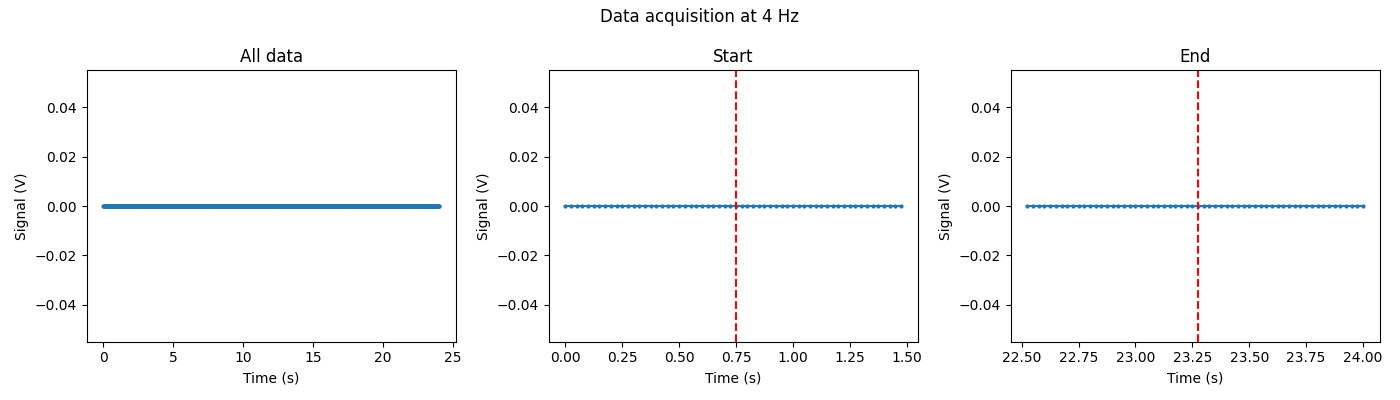

In [38]:
fig, ax = plt.subplots(1, 3 , figsize = (14, 4))
fig.suptitle(f"Data acquisition at {frequency} Hz")
per_to_show = 6
ax[0].plot(time_stamps, DAQ_signal, '-o', markersize=2)
ax[0].set_title("All data")
ax[1].plot(time_stamps[:per_to_show*p_period], DAQ_signal[:per_to_show*p_period], '-o', markersize=2)
ax[1].axvline(x = time_stamps[3*p_period], color = 'r', linestyle = '--')
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Start")
ax[2].plot(time_stamps[-per_to_show*p_period:], DAQ_signal[-per_to_show*p_period:], '-o', markersize=2)
ax[2].axvline(x = time_stamps[-3*p_period], color = 'r', linestyle = '--')
ax[2].set_ylim(ax[0].get_ylim())
ax[2].set_title("End")

for a in ax:
    a.set_xlabel("Time (s)")
    a.set_ylabel("Signal (V)")

fig.tight_layout()

fig.savefig(experiment_folder + EXPNAME + ".png", dpi = 300)